In [1]:
import numpy as np
import os
import pandas as pd

In [56]:
'''''This script demonstrates how to build a variational autoencoder with Keras. 
 
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114 
'''  
import numpy as np  
import matplotlib.pyplot as plt  
from scipy.stats import norm  
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Lambda  
from keras.models import Model  
from keras import backend as K  
from keras import objectives  
from keras.datasets import mnist  
from keras.utils.vis_utils import plot_model  
import sys  
  

batch_size = 100  
original_dim = 256   
latent_dim = 2
intermediate_dim = 128
nb_epoch = 50  
epsilon_std = 1.0  
  
#my tips:encoding  
x = Input(shape=(original_dim,))  
h = Dense(intermediate_dim, activation='relu')(x)  
z_mean = Dense(latent_dim,kernel_initializer=RandomNormal(mean=1, stddev=0.2, seed=None))(h)  
z_log_var = Dense(latent_dim)(h)  
z1_mean  = Dense(latent_dim,kernel_initializer=RandomNormal(mean=-1, stddev=0.2, seed=None))(h)
z1_log_var = Dense(latent_dim)(h)


#my tips:Gauss sampling,sample Z  
def sampling(args):   
    z_mean, z_log_var = args  
    epsilon_1 = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    epsilon_2 = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std) 
    return 0.5*(z_mean + K.exp(z_log_var / 2)* epsilon_1) + 0.5*(z1_mean + K.exp(z1_log_var / 2)* epsilon_2)



z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

 
decoder_h = Dense(intermediate_dim, activation='relu')(z) 
decoder_mean = Dense(original_dim, activation='sigmoid')(decoder_h)




def vae_loss(x, decoder_mean):  
    xent_loss = original_dim * objectives.binary_crossentropy(x,decoder_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)  
    return xent_loss + 10*kl_loss  

vae = Model(x, decoder_mean) 
import keras
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

vae.compile(optimizer='rmsprop', loss=vae_loss)  

newdata = pd.read_csv("ISING_simul/IsingModel16_16simul.csv").values
for i in range(len(newdata)):
    for j in range(len(newdata[0])):
        newdata[i][j] = (newdata[i][j]+1)/2
index = [i for i in range(len(newdata))]
import random
random.shuffle(index)
newdata = newdata[index]
x_train = newdata[:15000]
x_test = newdata[15000:20000]





In [57]:
vae.fit(x_train, x_train,  
        shuffle=True,  
        nb_epoch=nb_epoch,  
        #verbose=2,  
        batch_size=100,  
        validation_data=(x_test, x_test),callbacks=[EarlyStopping])  

/Users/sunhop/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 15000 samples, validate on 5000 samples
Epoch 1/50
15000/15000 [==============================] - 1s - loss: 354.4842 - val_loss: 156.1069
Epoch 2/50
15000/15000 [==============================] - 0s - loss: 156.0152 - val_loss: 154.4586
Epoch 3/50
15000/15000 [==============================] - 0s - loss: 155.5240 - val_loss: 154.2173
Epoch 4/50
15000/15000 [==============================] - 0s - loss: 155.4100 - val_loss: 154.0741
Epoch 5/50
15000/15000 [==============================] - 0s - loss: 155.3517 - val_loss: 154.1890
Epoch 6/50
15000/15000 [==============================] - 0s - loss: 155.3718 - val_loss: 154.1662
Epoch 7/50
15000/15000 [==============================] - 0s - loss: 155.3471 - val_loss: 154.1011
Epoch 8/50
15000/15000 [==============================] - 0s - loss: 155.3329 - val_loss: 154.0798
Epoch 9/50
15000/15000 [==============================] - 0s - loss: 154.6128 - val_loss: 152.2540
Epoch 10/50
15000/15000 [==============================] - 0

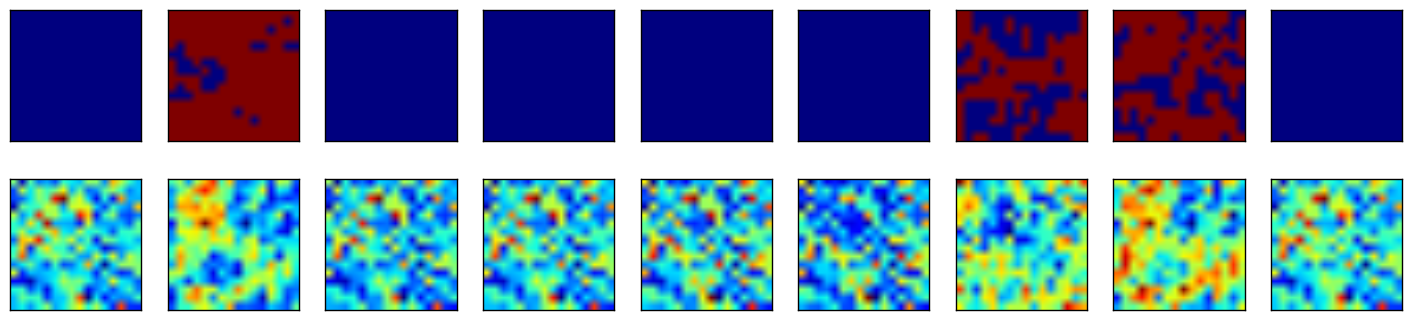

In [58]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)
decoded_imgs = vae.predict(x_test,batch_size=100)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow(np.round(x_test[i].reshape(16, 16)))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i].reshape(16,16)))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

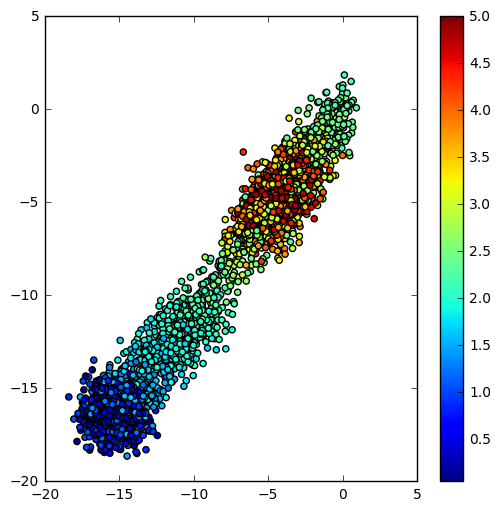

In [59]:
T = np.zeros((20099,))
u=5.025
for i in range(20099):
    
    if i%101==0:
        u = u- 0.025
    T[i]=u
T = T[index]

T_train = T[:15000]
T_test = T[15000:20000]
y_test = np.zeros((len(x_test),))
for i in range(len(x_test)):
    y_test[i]= np.sum(x_test[i])

encoder = Model(x, z)
  
# display a 2D plot of the digit classes in the latent space  
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)  
plt.figure(figsize=(6, 6))  
plt.scatter( x_test_encoded[:, 0] ,x_test_encoded[:, 1], c=T_test)  
plt.colorbar()  
plt.show()  
  


In [60]:
#itworks!